**Installing and Loading in Necessary Libraries**

In [ ]:
!pip install mtcnn
!pip install deepface

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reading in data

In [3]:
import pandas as pd

file_path = '/content/drive/MyDrive/icml_face_data.csv'
df = pd.read_csv(file_path)

df.columns = ['emotion', 'usage', 'pixels']
df.head()

,emotion,usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


Number of training, test, and validation images

In [4]:
print(f"Num Images:{df.shape[0]}")
print(f"Train, Test, Validation split")
print(df.usage.value_counts())

Num Images:35887
Train, Test, Validation split
Training       28709
PublicTest      3589
PrivateTest     3589
Name: usage, dtype: int64


Data Exploration

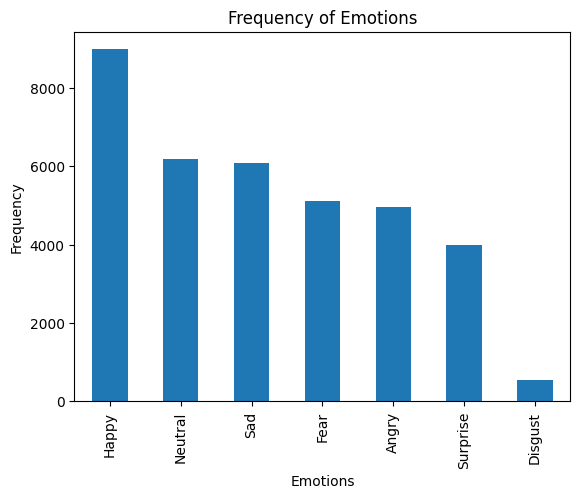

In [4]:
import matplotlib.pyplot as plt

emotion_map = {0: "Angry", 1: "Disgust", 2: "Fear", 3: "Happy", 4: "Sad", 5: "Surprise", 6: "Neutral"}
emotion_counts = df.emotion.map(emotion_map).value_counts()

emotion_counts.plot(kind='bar')
plt.xlabel('Emotions')
plt.ylabel('Frequency')
plt.title('Frequency of Emotions')
plt.show()

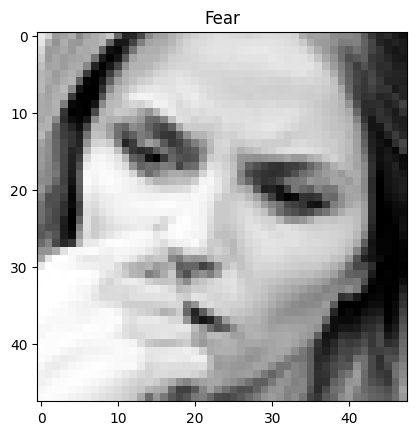

In [16]:
import numpy as np
import matplotlib.pyplot as plt


def display_image_with_emotion(image_index: int):

  ex_image = df.pixels.values[image_index]
  corresponding_emotion = df.emotion.map(emotion_map).values[image_index]

  pixel_list = [int(pix) for pix in ex_image.split()]
  image_array = np.array(pixel_list).reshape(48, 48)

  plt.imshow(image_array, cmap='gray')
  plt.title(corresponding_emotion)  
  plt.show()

display_image_with_emotion(image_index=2)

Drawing bounding box over face

1/1 [==============================] - 0s 219ms/step


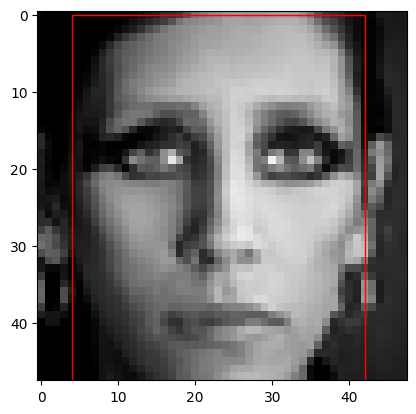

In [6]:
import matplotlib.patches as patches
import numpy as np
import cv2
from mtcnn import MTCNN
from PIL import Image

def get_face_bounding_box(image_array):

    detector = MTCNN()
    faces = detector.detect_faces(image_array)

    if faces:
        x, y, width, height = faces[0]['box']
        return x, y, x + width, y + height
    else:
        return None

ex_image = df.pixels.values[4]
pixel_list = [int(pix) for pix in ex_image.split()]
image_array = np.array(pixel_list).reshape(48, 48).astype(np.uint8)
image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

bbox = get_face_bounding_box(image_array=image_array)

def display_image_with_bbox(image_array, bbox):
    fig, ax = plt.subplots(1)
    ax.imshow(image_array)

    if bbox:
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

display_image_with_bbox(image_array, bbox)

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import skimage.io
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization ,Activation
from tensorflow.keras.models import Model, Sequential
from keras.applications.nasnet import NASNetLarge
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam

Pre-processing the images to be ready for training

In [29]:
def preprocess_data(data):
    # Convert the pixel values from integers to floats
    pixels = data['pixels'].tolist()
    pixels = [np.fromstring(pixel, dtype=int, sep=' ') for pixel in pixels]
    pixels = np.array(pixels, dtype=float)

    # Normalize the pixel values (between 0 and 1)
    pixels /= 255

    # Reshape the pixel values from a 1D array to a 3D array
    pixels = pixels.reshape(pixels.shape[0], 48, 48, 1)

    # Convert the emotion labels from integers to categorical values
    emotions = pd.get_dummies(data['emotion']).to_numpy()

    return pixels, emotions

train_data = df[df['usage'] == 'Training']
validation_data = df[df['usage'] == 'PublicTest']
test_data = df[df['usage'] == 'PrivateTest']

X_train, y_train = preprocess_data(train_data)
X_validation, y_validation = preprocess_data(validation_data)
X_test, y_test = preprocess_data(test_data)

This model architecture is a basic Convolutional Neural Network (CNN) designed for a computer vision classification problem. It consists of three convolutional layers with kernel sizes of 3x3 and increasing filter sizes (32, 64, and 128) followed by ReLU activation functions. These convolutional layers are interspersed with max-pooling layers, which downsample the feature maps to reduce the spatial dimensions and computational complexity. After the last convolutional layer, the model flattens the feature maps and passes them through three fully connected (dense) layers with decreasing neuron counts (128, 64, and 32), all activated by ReLU functions. The final layer has 7 output neurons with a softmax activation, which is suitable for multi-class classification tasks.

The benefits of this architecture are its simplicity and relatively low computational requirements, making it faster to train and more manageable on limited resources. This model is suited for computer vision classification problems because the convolutional layers learn spatial features and hierarchies while the max-pooling layers help with translational invariance. The dense layers at the end of the architecture learn the high-level features and make the final classification decision.

However, the downsides of this architecture include limited capacity to learn complex features and patterns when compared to more advanced models like ResNet, Inception, or MobileNet. For more complex tasks, the performance of this basic CNN might not be sufficient. Additionally, this architecture does not include any regularization techniques like dropout or batch normalization, which could help improve generalization and reduce overfitting.

In [8]:
with tf.device('/GPU:0'):
    # Create the model
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    basic_cnn_model = tf.keras.Model(inputs, outputs)

    # Compile the model
    tf.config.optimizer.set_experimental_options({"passes": ["loop-fusion"]})
    basic_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    basic_cnn_history = basic_cnn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=128)

    # Evaluate the model on the test data
    test_loss, test_acc = basic_cnn_model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)

Epoch 1/10
281/281 [==============================] - 204s 711ms/step - loss: 1.6822 - accuracy: 0.3276 - val_loss: 1.5175 - val_accuracy: 0.4139
Epoch 2/10
281/281 [==============================] - 200s 714ms/step - loss: 1.4290 - accuracy: 0.4501 - val_loss: 1.3024 - val_accuracy: 0.5025
Epoch 3/10
281/281 [==============================] - 220s 785ms/step - loss: 1.2829 - accuracy: 0.5086 - val_loss: 1.2067 - val_accuracy: 0.5401
Epoch 4/10
281/281 [==============================] - 196s 699ms/step - loss: 1.1921 - accuracy: 0.5489 - val_loss: 1.1112 - val_accuracy: 0.5800
Epoch 5/10
281/281 [==============================] - 201s 715ms/step - loss: 1.1087 - accuracy: 0.5818 - val_loss: 1.0313 - val_accuracy: 0.6134
Epoch 6/10
281/281 [==============================] - 197s 703ms/step - loss: 1.0358 - accuracy: 0.6136 - val_loss: 0.9350 - val_accuracy: 0.6546
Epoch 7/10
281/281 [==============================] - 198s 706ms/step - loss: 0.9596 - accuracy: 0.6430 - val_loss: 0.8415 -

Our next iteration was a basic CNN with separable layers, which reduced the number of trainable parameters. This will increase training speeed and decrease the memory usage of this model, while not significantly impacting accuracy. 

In [8]:
import tensorflow as tf

with tf.device('/GPU:0'):
    # Create the model
    inputs = tf.keras.Input(shape=(48, 48, 1))
    x = tf.keras.layers.SeparableConv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.SeparableConv2D(filters=64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.SeparableConv2D(filters=128, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    separable_cnn_model = tf.keras.Model(inputs, outputs)

    # Compile the model
    tf.config.optimizer.set_experimental_options({"passes": ["loop-fusion"]})
    separable_cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    separable_cnn_history = separable_cnn_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=128)

    # Evaluate the model on the test data
    test_loss, test_acc = separable_cnn_model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)

281/281 [==============================] - 125s 439ms/step - loss: 1.8114 - accuracy: 0.2458 - val_loss: 1.7811 - val_accuracy: 0.2505
Epoch 2/10
281/281 [==============================] - 129s 459ms/step - loss: 1.6489 - accuracy: 0.3396 - val_loss: 1.5397 - val_accuracy: 0.4021
Epoch 3/10
281/281 [==============================] - 137s 490ms/step - loss: 1.5038 - accuracy: 0.4144 - val_loss: 1.4637 - val_accuracy: 0.4337
Epoch 4/10
281/281 [==============================] - 139s 496ms/step - loss: 1.4246 - accuracy: 0.4492 - val_loss: 1.3634 - val_accuracy: 0.4767
Epoch 5/10
281/281 [==============================] - 137s 487ms/step - loss: 1.3528 - accuracy: 0.4760 - val_loss: 1.2954 - val_accuracy: 0.5077
Epoch 6/10
281/281 [==============================] - 124s 440ms/step - loss: 1.2891 - accuracy: 0.5051 - val_loss: 1.2296 - val_accuracy: 0.5348
Epoch 7/10
281/281 [==============================] - 136s 486ms/step - loss: 1.2294 - accuracy: 0.5303 - val_loss: 1.1732 - val_accura

This model architecture utilizes MobileNetV2 as its base, which is a highly efficient and lightweight Convolutional Neural Network (CNN) designed for computer vision classification tasks. MobileNetV2 is built upon the concept of depthwise separable convolutions, which factorize standard convolutions into depthwise and pointwise convolutions, reducing computational complexity and the number of trainable parameters. In this specific implementation, the alpha parameter is set to 0.35, which further reduces the model size and computational requirements by controlling the width of the network.

The base model processes the input of shape (48, 48, 1) and generates feature maps. The output feature maps are then passed through a Global Average Pooling 2D layer, which reduces the spatial dimensions to a single scalar per feature map. This output is connected to a fully connected (dense) layer with 128 neurons and a ReLU activation function, followed by a final dense layer with 7 output neurons and a softmax activation for multi-class classification.

The benefits of this architecture include its high efficiency, fast training, and low computational requirements, making it suitable for real-time applications or deployment on devices with limited resources. Additionally, MobileNetV2 is designed to strike a balance between model complexity and performance, which allows it to achieve competitive accuracy in various computer vision tasks.

The potential downsides of this architecture are that it might not achieve the same level of accuracy as more complex models like ResNet or Inception on highly complicated tasks. However, the trade-off between performance and computational efficiency is generally acceptable for many computer vision classification problems.

In [30]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2

with tf.device('/GPU:0'):
    # Create the model
    base_model = MobileNetV2(input_shape=(48, 48, 1), include_top=False, weights=None, alpha=0.35)
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    outputs = tf.keras.layers.Dense(7, activation='softmax')(x)
    
    mobile_net_model = tf.keras.Model(inputs=base_model.input, outputs=outputs)
    
    # Compile the model
    mobile_net_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    mobile_net_history = mobile_net_model.fit(X_train, y_train, validation_data=(X_validation, y_validation), epochs=10, batch_size=128)

    # Evaluate the model on the test data
    test_loss, test_acc = mobile_net_model.evaluate(X_test, y_test)
    print('Test accuracy:', test_acc)

Epoch 1/10
225/225 [==============================] - 176s 659ms/step - loss: 1.8158 - accuracy: 0.2476 - val_loss: 1.9158 - val_accuracy: 0.2494
Epoch 2/10
225/225 [==============================] - 145s 642ms/step - loss: 1.7558 - accuracy: 0.2821 - val_loss: 1.8890 - val_accuracy: 0.2494
Epoch 3/10
225/225 [==============================] - 137s 611ms/step - loss: 1.7044 - accuracy: 0.3099 - val_loss: 1.8745 - val_accuracy: 0.2494
Epoch 4/10
225/225 [==============================] - 139s 620ms/step - loss: 1.6425 - accuracy: 0.3444 - val_loss: 1.8589 - val_accuracy: 0.2494
Epoch 5/10
225/225 [==============================] - 140s 621ms/step - loss: 1.5720 - accuracy: 0.3821 - val_loss: 1.8524 - val_accuracy: 0.2494
Epoch 6/10
225/225 [==============================] - 141s 627ms/step - loss: 1.5212 - accuracy: 0.4085 - val_loss: 1.8481 - val_accuracy: 0.2494
Epoch 7/10
225/225 [==============================] - 139s 619ms/step - loss: 1.4717 - accuracy: 0.4323 - val_loss: 1.8447 -

Model evaluation

In [9]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(history, model):

    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

    pred_test_labels = model.predict(X_test)

    # Calculate overall accuracy
    overall_accuracy = accuracy_score(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))
    print(f"Overall accuracy: {overall_accuracy:.4f}")

    conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels.argmax(axis=1))

    # Normalize confusion matrix to show percentages
    normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

    disp = ConfusionMatrixDisplay(confusion_matrix=normalized_conf_mat,
                                  display_labels=emotion_map.values())
    disp.plot(cmap=plt.cm.Blues, values_format=".2%")
    plt.show()

Evaluating basic CNN model

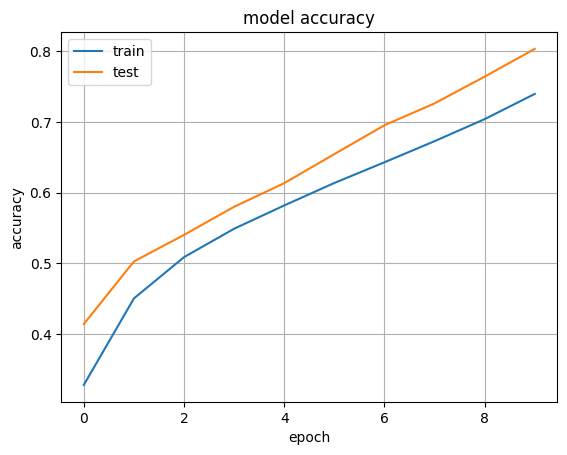

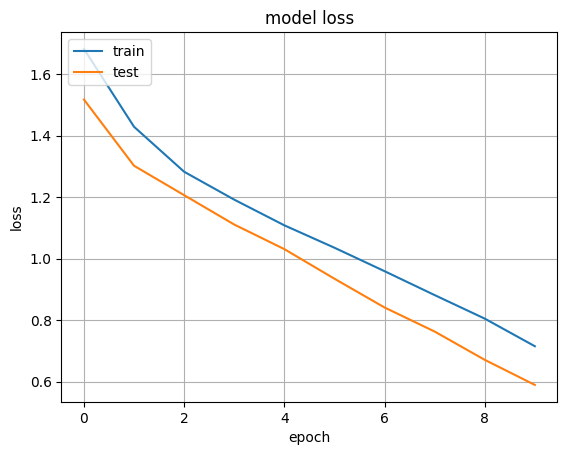

1122/1122 [==============================] - 44s 39ms/step
Overall accuracy: 0.8036


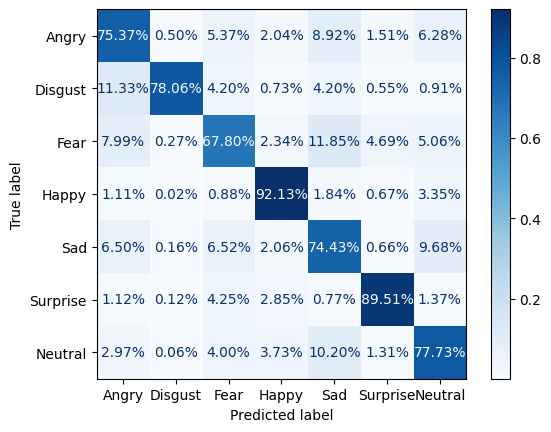

In [10]:
evaluate_model(history=basic_cnn_history, 
               model=basic_cnn_model)

Evaluating Separable CNN Model

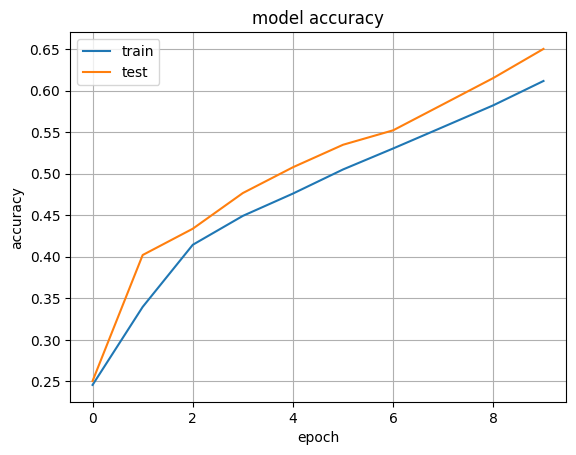

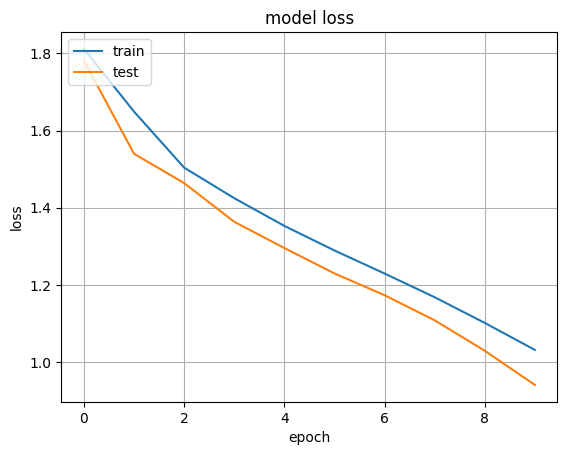

1122/1122 [==============================] - 29s 26ms/step
Overall accuracy: 0.6501


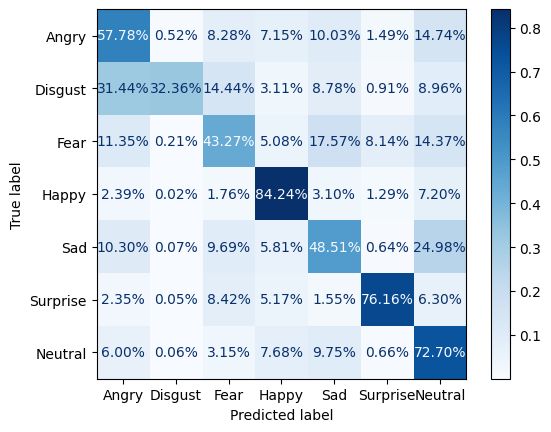

In [10]:
evaluate_model(history=separable_cnn_history, 
               model=separable_cnn_model)

Evaluating Mobile Net model

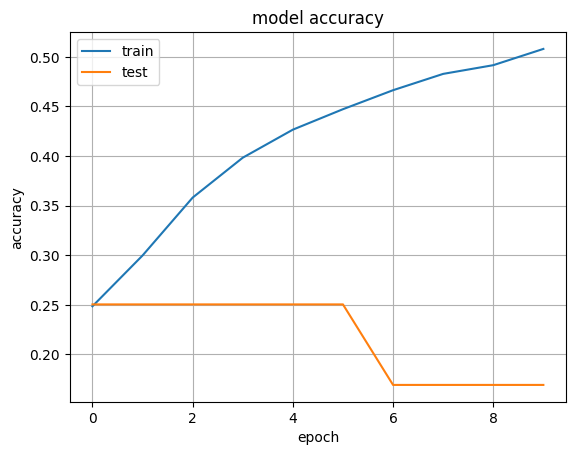

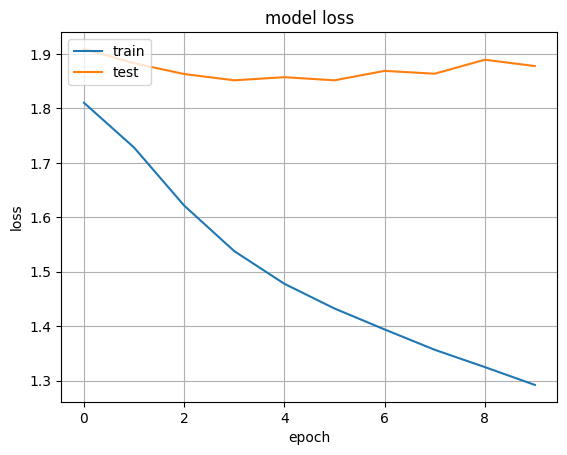

1122/1122 [==============================] - 36s 32ms/step
Overall accuracy: 0.1693


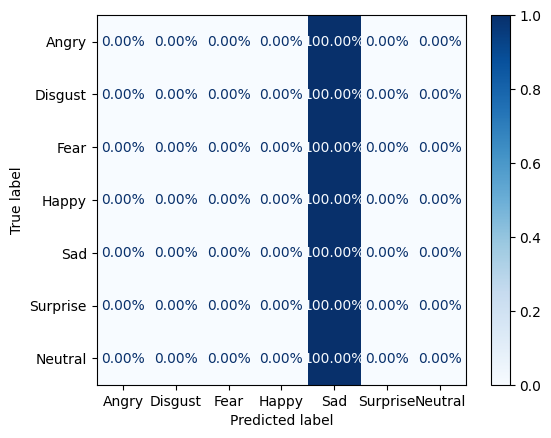

In [12]:
evaluate_model(history=mobile_net_history, 
               model=mobile_net_model)

Comparison to DeepFace model

In [20]:
from deepface import DeepFace
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def convert_images(X_test):
    converted_images = []
    for img in X_test:
        img = np.squeeze(img * 255).astype(np.uint8)  # Denormalize, remove extra dimension, and convert to uint8
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
        img = cv2.resize(img, (152, 152))  # Resize the image to DeepFace's expected input size
        converted_images.append(img)
    return np.array(converted_images)

X_test_converted = convert_images(X_test)

In [ ]:
pred_test_labels = []
total_num_images = len(X_test_converted)
for index, img in enumerate(X_test_converted):
    result = DeepFace.analyze(img, actions=["emotion"], enforce_detection=False)
    pred_test_labels.append(result[0]["dominant_emotion"])
    print(f"Finished Image {index} / {total_num_images}")

In [27]:
y_test

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]], dtype=uint8)

Overall accuracy: 0.4999


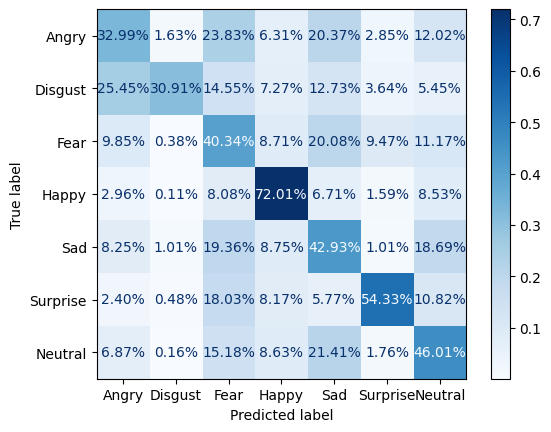

In [28]:
reverse_emotion_map = {"angry": 0, "disgust": 1, "fear": 2, "happy": 3, "sad": 4, "surprise": 5, "neutral": 6}
pred_test_labels_converted = pd.get_dummies([reverse_emotion_map[label] for label in pred_test_labels]).to_numpy()

# Calculate overall accuracy
overall_accuracy = accuracy_score(y_test.argmax(axis=1), pred_test_labels_converted.argmax(axis=1))
print(f"Overall accuracy: {overall_accuracy:.4f}")

conf_mat = confusion_matrix(y_test.argmax(axis=1), pred_test_labels_converted.argmax(axis=1))

# Normalize confusion matrix to show percentages
normalized_conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

disp = ConfusionMatrixDisplay(confusion_matrix=normalized_conf_mat,
                              display_labels=emotion_map.values())
disp.plot(cmap=plt.cm.Blues, values_format=".2%")
plt.show()

Saving basic CNN model

In [12]:
basic_cnn_model.save("basic_cnn_model.h5")

Saving basic CNN model with Separable layers

In [11]:
separable_cnn_model.save("separable_cnn_model.h5")

Saving MobileNet Model

In [9]:
mobile_net_model.save("mobile_net_model.h5")